In [1]:
from config import setup, import_and_display_fnc

setup()
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from common import (
    gauss_rule,
    qbx_matrix,
    symbolic_eval,
    qbx_setup,
    double_layer_matrix,
    PanelSurface,
    panelize_symbolic_surface,
    build_panel_interp_matrix,
)
import sympy as sp

In [3]:
%matplotlib inline

In [4]:
import_and_display_fnc('common', 'refine_panels')
import_and_display_fnc('common', 'stage1_refine')

def refine_panels(panels, which):
    new_panels = []
    for i in range(panels.shape[0]):
        if which[i]:
            left, right = panels[i]
            midpt = 0.5 * (left + right)
            new_panels.append([left, midpt])
            new_panels.append([midpt, right])
        else:
            new_panels.append(panels[i])
    new_panels = np.array(new_panels)
    return new_panels

def stage1_refine(
    sym_surf,
    quad_rule,
    other_surfaces=[],
    initial_panels=np.array([[-1, 1]]),
    control_points=None,
    max_iter=30,
):
    cur_panels = initial_panels.copy()

    other_surf_trees = []
    for other_surf in other_surfaces:
        other_surf_trees.append(scipy.spatial.KDTree(other_surf.panel_centers))

    if control_points is not None:
        control_tree = scipy.spatial.KDTree(control_points[:, :2])

    for i in range(max_iter):
        # Step 0) Create a PanelSurface from the current set of panels.
        # note that this step would need to look different if the surface were
        # defined from an input segment geometry rather than from a symbolic
        # curve specification.
        cur_surf = panelize_symbolic_surface(
            sym_surf[0], sym_surf[1], sym_surf[2], cur_panels, *quad_rule
        )

        # Step 1) Refine based on radius of curvature
        panel_radius = np.min(
            cur_surf.radius.reshape((-1, quad_rule[0].shape[0])), axis=1
        )
        refine_from_radius = cur_surf.panel_length > 0.25 * panel_radius

        # Step 2) Refine based on a nearby user-specified control points.
        if control_points is not None:
            nearby_controls = control_tree.query(cur_surf.panel_centers)
            nearest_control_pt = control_points[nearby_controls[1], :]
            refine_from_control = (
                nearby_controls[0]
                < 0.5 * cur_surf.panel_length + nearest_control_pt[:, 2]
            ) & (cur_surf.panel_length > nearest_control_pt[:, 3])
        else:
            refine_from_control = np.zeros(cur_surf.n_panels, dtype=bool)

        # Step 3) Refine based on the length scale imposed by other nearby surfaces
        refine_from_nearby = np.zeros(cur_surf.n_panels, dtype=bool)
        for j, other_surf in enumerate(other_surfaces):
            nearby_surf_panels = other_surf_trees[j].query(cur_surf.panel_centers)
            nearby_dist = nearby_surf_panels[0]
            nearby_panel_length = other_surf.panel_length[nearby_surf_panels[1]]
            refine_from_nearby |= (
                0.5 * nearby_panel_length + nearby_dist < cur_surf.panel_length
            )

        # Step 4) Ensure that panel length scale doesn't change too rapidly. This
        # essentially imposes that a panel will be no more than twice the length
        # of any adjacent panel.
        if cur_surf.n_panels > 1:
            panel_tree = scipy.spatial.KDTree(cur_surf.panel_centers)
            # Use k=2 because the closest panel will be the query panel itself.
            nearby_panels = panel_tree.query(cur_surf.panel_centers, k=2)
            nearby_dist = nearby_panels[0][:, 1]
            nearby_idx = nearby_panels[1][:, 1]
            nearby_panel_length = cur_surf.panel_length[nearby_idx]
            # The criterion will be: self_panel_length + sep < 0.5 * panel_length
            # but since sep = self_dist - 0.5 * panel_length - 0.5 * self_panel_length
            # we can simplify the criterion to:
            # Since the self distance metric is symmetric, we only need to check
            # if the panel is too large.
            fudge_factor = 0.01
            refine_from_self = (
                0.5 * nearby_panel_length + nearby_dist
                < (1 - fudge_factor) * cur_surf.panel_length
            )
        else:
            refine_from_self = np.zeros(cur_surf.n_panels, dtype=bool)

        refine = (
            refine_from_control
            | refine_from_radius
            | refine_from_self
            | refine_from_nearby
        )
        new_panels = refine_panels(cur_panels, refine)

        # TODO: add a callback for debugging? or some logging?
        #     plt.plot(s.pts[s.panel_start_idxs,0], s.pts[s.panel_start_idxs,1], 'k-*')
        #     plt.show()
        #     print('nearby_controls: ', nearby_controls, 0.5*panel_length, control_points[nearby_controls[1], 2])
        #     print('panel centers', pan

In [5]:
qx, qw = gauss_rule(16)
t = sp.var("t")

sym_obs_surf = (t, -t * 1000, 0 * t)
sym_src_surf = (t, t * 0, (t + 1) * -0.5)
src_panels = np.array([[-1, 1]])
src_surf = panelize_symbolic_surface(
    *sym_src_surf, src_panels, qx, qw
)

control_points = np.array([(0, 0, 2, 0.5)])
obs_surf = stage1_refine(
    sym_obs_surf, (qx, qw), other_surfaces=[src_surf], control_points=control_points
)

done after n_iterations=19 with n_panels=46


In [6]:
%matplotlib widget
plt.figure()
plt.plot(obs_surf.pts[obs_surf.panel_start_idxs,0], obs_surf.pts[obs_surf.panel_start_idxs,1], 'k-*')
plt.xlim([-25,25])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [7]:
from common import qbx_panel_setup, build_interp_matrix, build_interpolator

expansions = qbx_panel_setup(obs_surf, direction=1, p=10)

In [8]:
import_and_display_fnc('common', 'build_panel_interp_matrix')
import_and_display_fnc('common', 'stage2_refine')

def build_panel_interp_matrix(in_n_panels, in_qx, panel_idxs, out_qx):
    n_out_panels = out_qx.shape[0]
    shape = (n_out_panels * out_qx.shape[1], in_n_panels * in_qx.shape[0])
    indptr = np.arange(n_out_panels + 1)
    indices = panel_idxs
    interp_mat_data = []
    for i in range(n_out_panels):
        single_panel_interp = build_interp_matrix(build_interpolator(in_qx), out_qx[i])
        interp_mat_data.append(single_panel_interp)
    return scipy.sparse.bsr_matrix((interp_mat_data, indices, indptr), shape)

def stage2_refine(surf, expansions, max_iter=30, distance_limit=0.49):
    stage2_panels = np.array(
        [np.arange(surf.n_panels), -np.ones(surf.n_panels), np.ones(surf.n_panels)]
    ).T
    panel_parameter_width = surf.panel_bounds[:, 1] - surf.panel_bounds[:, 0]
    expansion_tree = scipy.spatial.KDTree(expansions.pts)

    for i in range(max_iter):
        stage2_surf = build_stage2_panel_surf(surf, stage2_panels)

        min_panel_expansion_dist = np.min(
            expansion_tree.query(stage2_surf.pts)[0].reshape((-1, surf.panel_order)), axis=1
        )
        refine = min_panel_expansion_dist < distance_limit * stage2_surf.panel_length

        new_quad_panel_domains = refine_panels(stage2_panels[:,1:], refine)
        new_in_panel_idx = np.repeat(stage2_panels[:, 0], refine + 1)
        new_quad_panels = np.hstack((new_in_panel_idx[:, None], new_quad_panel_domains))

        if stage2_panels.shape[0] == new_quad_panels.shape[0]:
            break
        stage2_panels = new_quad_panels

    return stage2_surf

In [9]:
%matplotlib inline

In [10]:
stage2_surf = stage2_refine(src_surf, expansions)

In [69]:
%matplotlib widget
plt.figure()
plt.plot(stage2_surf.pts[stage2_surf.panel_start_idxs,0], stage2_surf.pts[stage2_surf.panel_start_idxs,1], 'k-*')
plt.plot(expansions.pts[:,0], expansions.pts[:,1], 'r*')
plt.axis('equal')
plt.xlim([-1,1])
plt.ylim([-1,0])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
t = sp.var("t")
theta = sp.pi + sp.pi * t
F = 0.98
u = F * sp.cos(theta)
v = F * sp.sin(theta)
x = 0.5 * (
    sp.sqrt(2 + 2 * u * sp.sqrt(2) + u ** 2 - v ** 2)
    - sp.sqrt(2 - 2 * u * sp.sqrt(2) + u ** 2 - v ** 2)
)
y = 0.5 * (
    sp.sqrt(2 + 2 * v * sp.sqrt(2) - u ** 2 + v ** 2)
    - sp.sqrt(2 - 2 * v * sp.sqrt(2) - u ** 2 + v ** 2)
)
x = (1.0 / F) * x * 100000
y = (1.0 / F) * y * 20000 - 20000

In [63]:
rounded_corner_box = stage1_refine((t, x, y), (qx, qw), control_points = [(0,0,10000,5000)], max_radius_ratio=10.0)

done after n_iterations=10 with n_panels=32


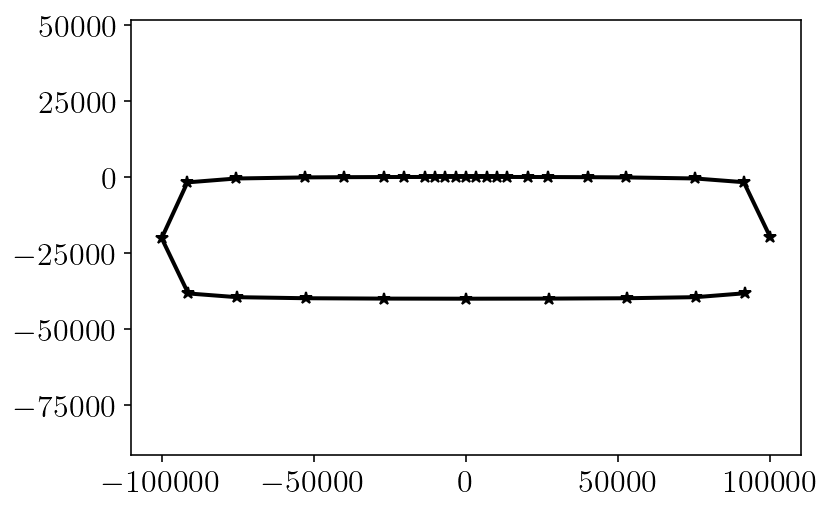

In [64]:
%matplotlib inline
plt.figure()
plt.plot(
    rounded_corner_box.pts[rounded_corner_box.panel_start_idxs, 0],
    rounded_corner_box.pts[rounded_corner_box.panel_start_idxs, 1],
    "k-*",
)
plt.axis("equal")
plt.show()

In [65]:
box_expansions = qbx_panel_setup(rounded_corner_box, direction=1, p=10)

48


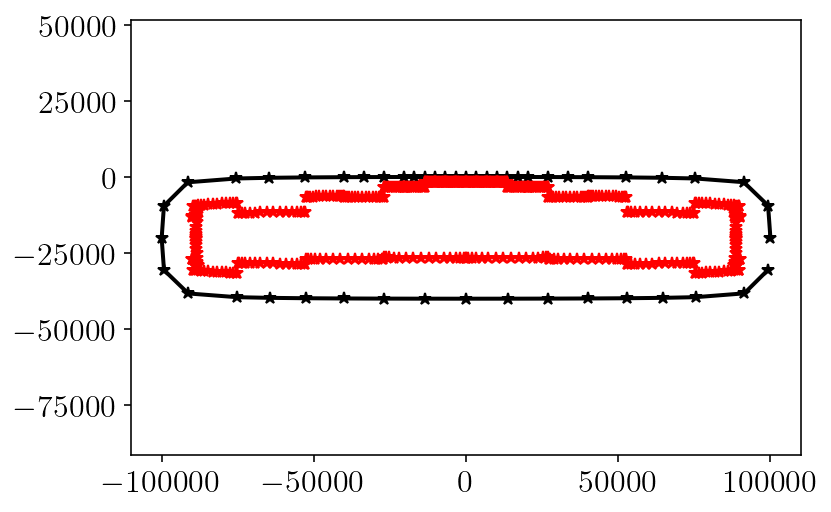

In [66]:
stage2_box = stage2_refine(rounded_corner_box, box_expansions)
print(stage2_box.n_panels)
plt.figure()
plt.plot(
    stage2_box.pts[stage2_box.panel_start_idxs, 0],
    stage2_box.pts[stage2_box.panel_start_idxs, 1],
    "k-*",
)
plt.plot(box_expansions.pts[:,0], box_expansions.pts[:,1], 'r*')
plt.axis("equal")
plt.show()